**Context**:

Assume the case study data is from a car manufacture optimizing its Supply Chain network across five regions (i.e. USA, Germany, Japan, Brazil, and India). You are given the demand, manufacturing capacity (thousands of cars) for each region, and the variable and fixed costs (thousands of $US dollars). Four Pandas DataFrames `demand`, `var_cost`, `fix_cost`, and `cap` have been created for you, and printed in the console, containing the regional demand, variable production costs, fixed production costs, and production capacity. The var_cost shows the costs of producing in location i shipping to location j. Which statement is true based on the data.

<img src="files/images/03_cpl1.PNG" width="500" align="center">
<img src="files/images/03_cpl2.PNG" width="500" align="center">
<img src="files/images/03_cpl3.PNG" width="500" align="center">
<img src="files/images/03_cpl4.PNG" width="500" align="center">
<img src="files/images/03_cpl5.PNG" width="500" align="center">

In [1]:
from pulp import *
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

**Data**

In [2]:
# Need to define the four dataframes: demand, var_cost, fix_cost, and cap
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low_Cap','High_Cap']
Dmd = {'Dmd': pd.Series(data = [2719.6, 84.1, 1676.8, 145.4, 156.4], index = loc)}
vc = {'USA': pd.Series(data = [6, 13, 20, 12, 22], index = loc), 
      'Germany': pd.Series(data = [13, 6, 14, 14, 13], index = loc), 
      'Japan': pd.Series(data = [20, 14, 3, 21, 10], index = loc), 
      'Brazil': pd.Series(data = [12, 14, 21, 8, 23], index = loc), 
      'India': pd.Series(data = [17, 13, 9, 21, 8], index = loc)}
fc = {'Low_Cap': pd.Series(data = [6500, 4980, 6230, 3230, 2110], index = loc), 
      'High_Cap': pd.Series(data = [9500, 7270, 9100, 4730, 3080], index = loc)}
cp = {'Low_Cap': pd.Series(data = [500, 500, 500, 500, 500], index = loc), 
      'High_Cap': pd.Series(data = [1500, 1500, 1500, 1500, 1500], index = loc)}
demand = pd.DataFrame(Dmd)
var_cost = pd.DataFrame(vc)
fix_cost = pd.DataFrame(fc)
cap = pd.DataFrame(cp)

In [3]:
demand

,Dmd
USA,2719.6
Germany,84.1
Japan,1676.8
Brazil,145.4
India,156.4


In [4]:
var_cost

,USA,Germany,Japan,Brazil,India
USA,6,13,20,12,17
Germany,13,6,14,14,13
Japan,20,14,3,21,9
Brazil,12,14,21,8,21
India,22,13,10,23,8


In [5]:
fix_cost

,Low_Cap,High_Cap
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,3080


In [6]:
cap

,Low_Cap,High_Cap
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,1500


In [7]:
# Initialize, and Define Decision Vars.
model = LpProblem("Capacitated_Plant_Location_Model", LpMinimize)
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low_Cap','High_Cap']
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc],
                     lowBound=0, upBound=None, cat='Continuous')
y = LpVariable.dicts("plant_", 
                     [(i,s) for s in size for i in loc], cat='Binary')

# Define objective function
model += (lpSum([fix_cost.loc[i,s] * y[(i,s)] 
                 for s in size for i in loc])
          + lpSum([var_cost.loc[i,j] * x[(i,j)] 
                   for i in loc for j in loc]))

# define the constraint that sets total production shipped to 
# a particular region equal to the total demand of that region
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) >= demand.loc[j,'Dmd']

# define constraint that sets total production of a particular region
# to be less than or equal to the total production capacity of that region
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s] * y[i,s] for s in size])

#Add a logical constraint so that if the high capacity plant in USA is open,
#then a low capacity plant in Germany is also opened.
#model += y[('USA', 'High_Cap')] - y[('Germany', 'Low_Cap')] <= 0

**Solving the Model**

In [8]:
model.solve()

1

In [9]:
# get the solution status
print('Status: ', LpStatus[model.status])

# print variables values
for v in model.variables():
    print(v.name, '=', v.varValue)
    
# objective value
print('Objective = ', value(model.objective))

Status:  Optimal
plant__('Brazil',_'High_Cap') = 1.0
plant__('Brazil',_'Low_Cap') = 0.0
plant__('Germany',_'High_Cap') = 0.0
plant__('Germany',_'Low_Cap') = 0.0
plant__('India',_'High_Cap') = 0.0
plant__('India',_'Low_Cap') = 1.0
plant__('Japan',_'High_Cap') = 1.0
plant__('Japan',_'Low_Cap') = 0.0
plant__('USA',_'High_Cap') = 1.0
plant__('USA',_'Low_Cap') = 0.0
production__('Brazil',_'Brazil') = 145.4
production__('Brazil',_'Germany') = 0.0
production__('Brazil',_'India') = 0.0
production__('Brazil',_'Japan') = 0.0
production__('Brazil',_'USA') = 1219.6
production__('Germany',_'Brazil') = 0.0
production__('Germany',_'Germany') = 0.0
production__('Germany',_'India') = 0.0
production__('Germany',_'Japan') = 0.0
production__('Germany',_'USA') = 0.0
production__('India',_'Brazil') = 0.0
production__('India',_'Germany') = 84.1
production__('India',_'India') = 156.4
production__('India',_'Japan') = 176.8
production__('India',_'USA') = 0.0
production__('Japan',_'Brazil') = 0.0
production__('J

**Print decision variables in a more readable format**

In [10]:
# production quantities
o = [{'prod':"{} to {}".format(i,j), 'quant':x[(i,j)].varValue} for i in loc for j in loc]
print(pd.DataFrame(o))

                  prod   quant
0           USA to USA  1500.0
1       USA to Germany     0.0
2         USA to Japan     0.0
3        USA to Brazil     0.0
4         USA to India     0.0
5       Germany to USA     0.0
6   Germany to Germany     0.0
7     Germany to Japan     0.0
8    Germany to Brazil     0.0
9     Germany to India     0.0
10        Japan to USA     0.0
11    Japan to Germany     0.0
12      Japan to Japan  1500.0
13     Japan to Brazil     0.0
14      Japan to India     0.0
15       Brazil to USA  1219.6
16   Brazil to Germany     0.0
17     Brazil to Japan     0.0
18    Brazil to Brazil   145.4
19     Brazil to India     0.0
20        India to USA     0.0
21    India to Germany    84.1
22      India to Japan   176.8
23     India to Brazil     0.0
24      India to India   156.4


In [11]:
# locations and capacity
o = [{'loc':i, 'lc':y[(i,size[0])].varValue, 'hc':y[(i,size[1])].varValue} for i in loc]
print(pd.DataFrame(o))

    hc   lc      loc
0  1.0  0.0      USA
1  0.0  0.0  Germany
2  1.0  0.0    Japan
3  1.0  0.0   Brazil
4  0.0  1.0    India


**Sanity Checking**

The solution is optimal. If it was not, then the model needs to be checked.

1. If **infeasible**: review the constraints
2. if **unbounded**: review the objective function
3. if **undefined**: optimal solution may exist but may not have been found
4. if **not solved**: then maybe you forgot to solve the model `model.solve()`

**Write LP** is a good starting point.
`writeLP(filename)` outputs a file containing: name of problem, objective function (and goal), constraints, and decision variables.

### Shadow price sensitivity analysis

(aka change in objective per one unit increase in the RHS, or constraints)

In [12]:
# print shadow price for each constraint
o = [{'name': name, 'shadow_price': c.pi} for name, c in model.constraints.items()]
print(pd.DataFrame(o))

   name  shadow_price
0   _C1          12.0
1   _C2          13.0
2   _C3          10.0
3   _C4           8.0
4   _C5           8.0
5   _C6          -6.0
6   _C7          -7.0
7   _C8          -7.0
8   _C9           0.0
9  _C10           0.0


### Constraint slack

slack: amount of a resource that's unused. If **zero**, then constraint is **binding**. Changing binding constraints changes solution.

In [13]:
# print shadow price and slack for each constraint
o = [{'name': name, 'shadow_price': c.pi, 'slack': c.slack} for name, c in model.constraints.items()]
print(pd.DataFrame(o))

   name  shadow_price  slack
0   _C1          12.0   -0.0
1   _C2          13.0   -0.0
2   _C3          10.0   -0.0
3   _C4           8.0   -0.0
4   _C5           8.0   -0.0
5   _C6          -6.0   -0.0
6   _C7          -7.0   -0.0
7   _C8          -7.0   -0.0
8   _C9           0.0  135.0
9  _C10           0.0   82.7


Notice that constraints with **zero** shadow price, have **non-zero** slacks, i.e. unused resources.

## Remember!

**Sensitivity Analysis** above (shadow price and slack) only valid when changing **one input at a time**. Use simulation (e.g. Monte Carlo) for a more comprehensive sensitivity analysis.

## Simulation Testing

Now, we add some random noise to estimates of demands, and variable costs to test the sensitivity of the solution to a change in these estimates (just in case the data was inaccurate).

This approach is also recommended for examining the readiness of a company/organization for various scenarios where the inputs may change. For example, examining the preparedness of a food or PPE equipment manufacturer supply chain for a sudden increase in demand due to a pandemic. 

**Modify objective function (variable costs)**

```Python
model += (lpSum([fix_cost.loc[i,s]*y[(i,s)] for s in size for i in loc]) 
         + lpSum([(var_cost.loc[i,j] + random.normalvariate(0.5, 0.5))*x[(i,j)] for i in loc for j in loc]))
```

**Modify demand constraints**

```Python
    for j in loc:
        # define a noise variable to be added to demand estimates
        rd = random.normalvariate(0, demand.loc[j,'Dmd']*.05)
        model += lpSum([x[(i,j)] for i in loc]) == (demand.loc[j,'Dmd']+rd)
```

**Define a function to run the model**

In [14]:
def run_pulp_model(fix_cost, var_cost, demand,cap):
    # Initialize Class
    model = LpProblem("Capacitated_Plant_Location_Model", LpMinimize)
    # Define Decision Variables
    loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
    size = ['Low_Cap','High_Cap']
    x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc], 
                         lowBound=0, upBound=None, cat='Continuous')
    y = LpVariable.dicts("plant_", [(i,s) for s in size for i in loc], 
                         cat='Binary')
    # objective function
    model += (lpSum([fix_cost.loc[i,s]*y[(i,s)] for s in size for i in loc]) 
              + lpSum([(var_cost.loc[i,j] + random.normalvariate(0.5, 0.5))*x[(i,j)] for i in loc for j in loc]))
    # Define the Constraints
    for j in loc:
        # define a noise variable to be added to demand estimates
        rd = random.normalvariate(0, demand.loc[j,'Dmd']*.05)
        model += lpSum([x[(i,j)] for i in loc]) == (demand.loc[j,'Dmd']+rd)
    for i in loc:
        model += lpSum([x[(i, j)] for j in loc]) <= lpSum([cap.loc[i,s] * y[i,s] for s in size])
    # Solve the model
    model.solve()
    # output dictionary
    o = {}
    # adding to output dictionary
    for i in loc:
        o[i] = value(lpSum([x[(i, j)] for j in loc]))
        o['Obj'] = value(model.objective)
    return(o)

In [15]:
# variable for number of replications
r = 1000
# define a list of dictionaries to hold the output of each replication
output = []
for i in range(r):
    output.append(run_pulp_model(fix_cost, var_cost, demand, cap))
df = pd.DataFrame(output)
df.head()

,Brazil,Germany,India,Japan,Obj,USA
0,1195.772610,0.0,355.639501,1500.0,61637.299150,1500.0
1,1438.493680,0.0,581.361504,1500.0,64061.789957,1500.0
2,1383.288970,0.0,401.618948,1500.0,62081.154106,1500.0
3,1499.999991,0.0,453.327104,1500.0,63327.302418,1500.0
4,1438.768000,0.0,360.931255,1500.0,64310.227956,1500.0


### Interpreting simulation results

**Production at each region**

Keep in mind that the production capacity for a low or high capacity plant is 500, or 1,500 respectively.

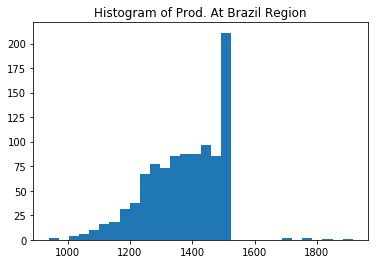

In [16]:
# Histogram of Brazilian production
plt.title('Histogram of Prod. At Brazil Region')
plt.hist(df['Brazil'], bins=30)
plt.show()

Although it's rare, but notice how it seems like the Brazil region sometimes uses both a high and low capacity plant for production, because there are instances where production is greater than 1,500 (horizontal axis).

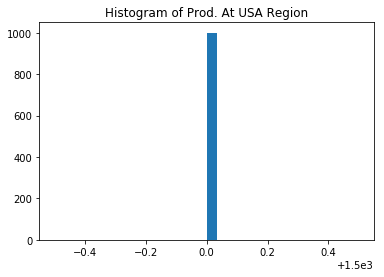

In [17]:
# Histogram of USA production
plt.title('Histogram of Prod. At USA Region')
plt.hist(df['USA'], bins=30)
plt.show()

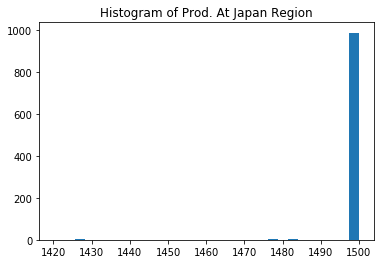

In [18]:
# Histogram of Japan production
plt.title('Histogram of Prod. At Japan Region')
plt.hist(df['Japan'], bins=30)
plt.show()

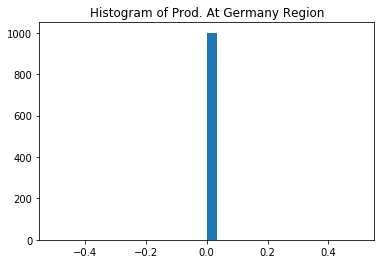

In [19]:
# Histogram of Germany production
plt.title('Histogram of Prod. At Germany Region')
plt.hist(df['Germany'], bins=30)
plt.show()

 Notice how USA, Japan, and Germany all have stable production quantities, where most of the times the result is the same. Also, notice how it seems that in the simulation, there were no instances when the German region produced any products.